In [23]:
import json
import paddle 
from paddlenlp.data import Stack,Tuple,Pad
import paddle.nn as nn
from matplotlib import pyplot as plt

# 加载数据

In [2]:
train_data=open('semeval_train.txt').readlines()
val_data=open('semeval_val.txt').readlines()
test_data=open('semeval_test.txt').readlines()
train_data=[json.loads(line.strip()) for line in train_data]
val_data=[json.loads(line.strip()) for line in val_data]
test_data=[json.loads(line.strip()) for line in test_data]

rel2id=json.loads(open("semeval_rel2id.json").read())
id2rel={v:k for k,v in rel2id.items()}
num_classes=len(list(rel2id))

In [3]:
print(train_data[0])
print('train_data:',len(train_data))
print('val_data:',len(val_data))
print("test_data:",len(test_data))

{'token': ['the', 'original', 'play', 'was', 'filled', 'with', 'very', 'topical', 'humor', ',', 'so', 'the', 'director', 'felt', 'free', 'to', 'add', 'current', 'topical', 'humor', 'to', 'the', 'script', '.'], 'h': {'name': 'play', 'pos': [2, 3]}, 't': {'name': 'humor', 'pos': [8, 9]}, 'relation': 'Component-Whole(e2,e1)'}
train_data: 6507
val_data: 1493
test_data: 2717


# 构建字典

In [4]:
vocab={}
vocab['<pad>'],vocab["<unk>"]=0,1
idx=2
for line in train_data + val_data:
    for w in line['token']:
        if w not in vocab:
            vocab[w]=idx
            idx+=1
chars='abcdefghijklmnopqrstuvwxyz'
for char in chars:
    if char not in vocab:
        vocab[char]=idx
        idx+=1

vocab_size=len(list(vocab))

maxlen=30


In [5]:
def txt_to_list(datas):
    sents,e1,e2,y=[],[],[],[]
    for line in datas:
        sents.append(line['token'])
        e1.append(line['h']['name'])
        e2.append(line['t']['name'])
        y.append(line['relation'])
    
    return sents,e1,e2,y


In [6]:
dic={}
def word2id(datas,maxlen=5):
    res=[]
    if maxlen<10:#只有e1,e2进这条路
        maxlen=10
        datas=[list(data) for data in datas]
    
    for data in datas:
        if len(data) not in dic:
            dic[len(data)]=1
        else:
            dic[len(data)]+=1#用于计算句子长度的占比

        line=[vocab[c] if c in vocab else vocab['<unk>'] for c in data][:maxlen]
        line=line+[vocab['<pad>']]*(maxlen-len(line))
        res.append(line)

    return res

In [7]:
train_sents,train_e1,train_e2,train_y=txt_to_list(train_data)
val_sents,val_e1,val_e2,val_y=txt_to_list(val_data)
test_sents,test_e1,test_e2,test_y=txt_to_list(test_data)



In [8]:
# train_sents=word2id(train_sents,maxlen)
# # print(train_sents.shape)
# print(type(train_sents))
# print(train_sents)
# train_sents=Stack()(train_sents)

In [9]:
# print(train_sents.shape)
# print(type(train_sents))
# print(train_sents)

In [10]:
train_idx=Stack()(word2id(train_sents,maxlen))
train_e1_idx=Stack()(word2id(train_e1,2))
train_e2_idx=Stack()(word2id(train_e2,2))
train_yid=[rel2id[c] for c in train_y]

val_idx=Stack()(word2id(val_sents,maxlen))
val_e1_idx=Stack()(word2id(val_e1,2))
val_e2_idx=Stack()(word2id(val_e2,2))
val_yid=[rel2id[c] for c in val_y]

test_idx=Stack()(word2id(test_sents,maxlen))
test_e1_idx=Stack()(word2id(test_e1,2))
test_e2_idx=Stack()(word2id(test_e2,2))
test_yid=[rel2id[c] for c in test_y]

# 构建数据集

In [11]:
class MyDataset(paddle.io.Dataset):
    def __init__(self,data):
        super(MyDataset,self).__init__()
        self.data=data
    
    def __getitem__(self,index):
        data,e1,e2,label=self.data[index]
        return data,e1,e2,label

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [str(c) for c in range(19)]

In [12]:
batch_size=64
use_gpu=True
train=MyDataset([[x,e1,e2,y] for x,e1,e2,y in zip(train_idx,train_e1_idx,train_e2_idx,train_yid)])
val=MyDataset([[x,e1,e2,y] for x,e1,e2,y in zip(val_idx,val_e1_idx,val_e2_idx,val_yid)])
test=MyDataset([[x,e1,e2,y] for x,e1,e2,y in zip(test_idx,test_e1_idx,test_e2_idx,test_yid)])

train_loader=paddle.io.DataLoader(train,batch_size=batch_size,shuffle=True)
val_loader=paddle.io.DataLoader(val,batch_size=batch_size,shuffle=False)
test_loader=paddle.io.DataLoader(test,batch_size=batch_size,shuffle=False)

# 搭建模型

In [13]:
class Model(nn.Layer):
    def __init__(self,vocab_size,embedding_size,hidden_size,dropout_rate,fc_hidden_size,num_layers=2):
        super(Model,self).__init__()
        self.hidden_size=hidden_size
        self.emb=paddle.nn.Embedding(vocab_size,embedding_size)
        self.lstm=nn.LSTM(embedding_size,hidden_size,num_layers=num_layers,direction='bidirectional')
        self.lstm_e1=nn.LSTM(embedding_size,hidden_size,num_layers=1)
        self.lstm_e2=nn.LSTM(embedding_size,hidden_size,num_layers=1)
        self.fc=nn.Linear(hidden_size*4,fc_hidden_size)
        self.output_layer=nn.Linear(fc_hidden_size,num_classes)
    
    def forward(self,text,e1,e2,y=None):
        emb_text=self.emb(text)
        emb_e1=self.emb(e1)
        emb_e2=self.emb(e2)
        r1,(_,_)=self.lstm(emb_text)
        r2,(_,_)=self.lstm_e1(emb_e1)
        r3,(_,_)=self.lstm_e2(emb_e2)
        f=paddle.concat([r1[:,-1,:self.hidden_size],r1[:,0,self.hidden_size:],r2[:,-1,:],r3[:,-1,:]],axis=-1)
        fc_out=paddle.tanh(self.fc(f))
        logits=self.output_layer(fc_out)
        return logits

# 训练

In [14]:
epochs=10
embedding_size=128
hidden_size=256
dropout_rate=0.1
fc_hidden_size=128
num_layers=3
model=Model(vocab_size,embedding_size,hidden_size,dropout_rate,fc_hidden_size,num_layers)

W0803 14:56:10.067515  8951 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0803 14:56:10.073068  8951 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


In [18]:
optimizer=paddle.optimizer.Adam(parameters=model.parameters(),learning_rate=5e-4)
loss_func=paddle.nn.CrossEntropyLoss()

In [19]:
steps=0
total_loss=[]
total_acc=[]
Iters=[]
for i in range(epochs):
    for data in train_loader:
        x,e1,e2,y=data
        steps+=1
        logits=model(x,e1,e2)
        pred=paddle.argmax(logits,axis=-1)
        acc=sum(pred.numpy()==y.numpy())/len(y)
        loss=loss_func(logits,y)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        if steps%30==0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc)
            print('epo:{},step:{},loss is :{},acc is: {}'.format(i,steps,loss.numpy(),acc))

    paddle.save(model.state_dict(),'model_{}.pdparams'.format(i))

epo:0,step:30,loss is :[2.8214874],acc is: 0.140625
epo:0,step:60,loss is :[2.799726],acc is: 0.140625
epo:0,step:90,loss is :[2.5845602],acc is: 0.171875
epo:1,step:120,loss is :[2.4073305],acc is: 0.234375
epo:1,step:150,loss is :[2.030932],acc is: 0.390625
epo:1,step:180,loss is :[2.2202737],acc is: 0.328125
epo:2,step:210,loss is :[1.7644681],acc is: 0.359375
epo:2,step:240,loss is :[1.5535717],acc is: 0.515625
epo:2,step:270,loss is :[1.8133805],acc is: 0.515625
epo:2,step:300,loss is :[1.8596356],acc is: 0.40625
epo:3,step:330,loss is :[1.0855057],acc is: 0.671875
epo:3,step:360,loss is :[1.2415042],acc is: 0.59375
epo:3,step:390,loss is :[1.0857097],acc is: 0.6875
epo:4,step:420,loss is :[0.90502274],acc is: 0.6875
epo:4,step:450,loss is :[0.79819643],acc is: 0.765625
epo:4,step:480,loss is :[0.94034004],acc is: 0.65625
epo:4,step:510,loss is :[1.1909661],acc is: 0.5813953488372093
epo:5,step:540,loss is :[0.51081467],acc is: 0.859375
epo:5,step:570,loss is :[0.41100276],acc is:

# 绘图

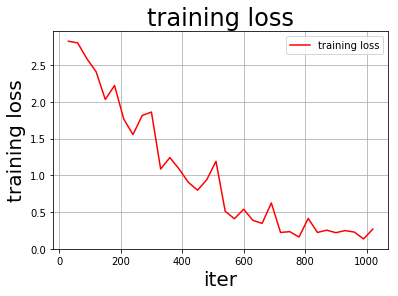

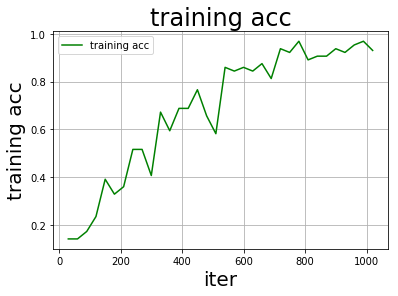

In [24]:
def draw_process(title,color,iters,data,label):
    plt.title(title,fontsize=24)
    plt.xlabel('iter',fontsize=20)
    plt.ylabel(label,fontsize=20)
    plt.plot(iters,data,color,label=label)
    plt.legend()
    plt.grid()
    plt.show()

draw_process("training loss","red",Iters,total_loss,"training loss")
draw_process("training acc","green",Iters,total_acc,"training acc")

# 评估

In [26]:
model.eval()
preds=[] 
steps=0
y=[]
for data in val_loader:
    x,e1,e2,y_=data
    steps+=1
    logits=model(x,e1,e2)
    pred=paddle.argmax(logits,axis=-1)
    y+=list(y_.numpy())
    preds+=list(pred.numpy())

cc=[1 if a==b else 0 for a,b in zip(preds,y)]
acc = sum(cc)/len(y)

# 预测

In [31]:
model.eval()
x=paddle.to_tensor(test_idx)
e1=paddle.to_tensor(test_e1_idx)
e2=paddle.to_tensor(test_e2_idx)
y=paddle.to_tensor(test_yid)

logits=model(x,e1,e2)

pred=paddle.argmax(logits,axis=-1)
for i in range(9):
    print('-'*30)
    print('上下文:'," ".join(test_sents[i]))
    print('实体1:',test_e1[i])
    print('实体2:',test_e2[i])
    print("真实标签:",test_y[i])
    print("预测标签:",id2rel[pred[i].numpy()[0]])

------------------------------
上下文: the most common audits were about waste and recycling .
实体1: audits
实体2: waste
真实标签: Message-Topic(e1,e2)
预测标签: Message-Topic(e1,e2)
------------------------------
上下文: this thesis defines the clinical characteristics of amyloid disease .
实体1: thesis
实体2: clinical characteristics
真实标签: Message-Topic(e1,e2)
预测标签: Other
------------------------------
上下文: this outline focuses on spirituality , esotericism , mysticism , religion and/or parapsychology .
实体1: outline
实体2: spirituality
真实标签: Message-Topic(e1,e2)
预测标签: Message-Topic(e1,e2)
------------------------------
上下文: many of his literary pieces narrate and mention stories that took place in lipa .
实体1: pieces
实体2: stories
真实标签: Message-Topic(e1,e2)
预测标签: Message-Topic(e1,e2)
------------------------------
上下文: news programs commented on the violence from the game and expressed worries on how it would affect the players ' personalities .
实体1: news programs
实体2: violence
真实标签: Message-Topic(e1,e2)
预测标